In [1]:
# Import libraries
import matplotlib.pyplot as plt
import pandas as pd
from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame

In [2]:
predictor = TimeSeriesPredictor.load('weekly_ACT_final')

In [3]:
# Load data of closing transaction
df = pd.read_csv('../CSV/df_TS_week.csv')
df.head()

,item_id,timestamp,target,ACT01,ACT03,ACT04,ACT07,ACT09,ACT13,ACT15,ACT17,ACT32,ACT34,ACT44
0,FR13,2019-12-30,7663.0,1267.0,299.0,0.0,2108.0,189.0,84.0,0.0,0.0,3716.0,0.0,0.0
1,FR13,2020-01-06,2917.0,1052.0,490.0,2.0,103.0,255.0,191.0,3.0,0.0,821.0,0.0,0.0
2,FR13,2020-01-13,2341.0,846.0,115.0,0.0,280.0,69.0,66.0,416.0,407.0,142.0,0.0,0.0
3,FR13,2020-01-20,3853.0,1350.0,932.0,44.0,568.0,297.0,278.0,81.0,80.0,223.0,0.0,0.0
4,FR13,2020-01-27,82251.0,1871.0,863.0,0.0,609.0,363.0,219.0,2.0,0.0,19393.0,0.0,58931.0


In [4]:
# Create a new df of the item_id equal to IT01 
df = df[df['item_id'] == 'IT01']

In [5]:
# Remove idem_id column and target column
df = df.drop(columns=['item_id', 'target'])
df.head()

,timestamp,ACT01,ACT03,ACT04,ACT07,ACT09,ACT13,ACT15,ACT17,ACT32,ACT34,ACT44
348,2019-12-30,1228.0,87.0,0.0,195.0,188.0,32.0,1817.0,1255.0,2811.0,0.0,0.0
349,2020-01-06,87.0,63.0,0.0,5.0,8.0,0.0,0.0,0.0,227.0,261.0,0.0
350,2020-01-13,161.0,10.0,0.0,14.0,0.0,49.0,1.0,0.0,467.0,0.0,0.0
351,2020-01-20,437.0,143.0,0.0,86.0,67.0,110.0,0.0,0.0,98.0,0.0,0.0
352,2020-01-27,403.0,457.0,0.0,178.0,108.0,48.0,7.0,0.0,269.0,0.0,0.0


In [6]:
# Trasforma le colonne ACT in una singola colonna item_id e i valori corrispondenti in una colonna target
df = df.melt(id_vars=["timestamp"], var_name="item_id", value_name="target")

# Ordina il DataFrame per il timestamp
df.sort_values(by="timestamp", inplace=True)

# Visualizza il DataFrame trasformato
df.head(10)

,timestamp,item_id,target
0,2019-12-30,ACT01,1228.0
172,2019-12-30,ACT03,87.0
1204,2019-12-30,ACT17,1255.0
860,2019-12-30,ACT13,32.0
1548,2019-12-30,ACT34,0.0
516,2019-12-30,ACT07,195.0
1376,2019-12-30,ACT32,2811.0
688,2019-12-30,ACT09,188.0
1032,2019-12-30,ACT15,1817.0
344,2019-12-30,ACT04,0.0


In [7]:
# Drop row where item_id is ACT17 and ACT44
df = df[df['item_id'] != 'ACT17']
df = df[df['item_id'] != 'ACT04']
df = df[df['item_id'] != 'ACT44']

In [8]:
prediction_length = 12  # Length of the prediction

# Convert the 'timestamp' column to datetime format if it's not already in that format
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Find the maximum date in the dataset
max_date = df['timestamp'].max()

# Calculate the start date of the test set
test_start_date = max_date - pd.DateOffset(weeks=prediction_length+1)

# Split the dataset into training and test sets
train_data = df[df['timestamp'] <= test_start_date]
test_data = df[df['timestamp'] > test_start_date]

# Print the percentage dimensions of the training and test sets
print(train_data.shape[0] / df.shape[0])
print(test_data.shape[0] / df.shape[0])


0.9244186046511628
0.0755813953488372


In [9]:
# Convert train_data to TimeSeriesDataFrame
train_data = TimeSeriesDataFrame(
    train_data, 
    id_column="item_id",
    timestamp_column="timestamp"
    
)

train_data.head()

,,target
item_id,timestamp,
ACT01,2019-12-30,1228.0
ACT03,2019-12-30,87.0
ACT13,2019-12-30,32.0
ACT34,2019-12-30,0.0
ACT07,2019-12-30,195.0


In [10]:
# Convert test_data to TimeSeriesDataFrame
test_data = TimeSeriesDataFrame(
    test_data, 
    id_column="item_id",
    timestamp_column="timestamp"
    
)

test_data.head()

,,target
item_id,timestamp,
ACT03,2023-01-30,147.0
ACT09,2023-01-30,166.0
ACT13,2023-01-30,196.0
ACT32,2023-01-30,2137.0
ACT15,2023-01-30,344.0


In [11]:
predictions = predictor.predict(train_data, random_seed=42)
predictions.head()

data with frequency 'None' has been resampled to frequency 'W-MON'.
data contains missing values represented by NaN. They have been filled by carrying forward the last valid observation.


mean         0.1         0.2         0.3  \
item_id timestamp                                                    
ACT01   2023-01-30  549.017538  349.942209  418.371423  452.073642   
        2023-02-06  193.010141   39.401528   95.889819  141.765131   
        2023-02-13  238.861680   66.489865  122.419582  164.558257   
        2023-02-20  391.713614  153.662577  233.543284  281.672923   
        2023-02-27  460.421225  232.612788  316.528611  375.160548   

                           0.4         0.5         0.6         0.7  \
item_id timestamp                                                    
ACT01   2023-01-30  506.637196  549.017538  613.268430  701.200359   
        2023-02-06  152.460292  193.010141  231.131991  286.261749   
        2023-02-13  197.401708  238.861680  279.678033  319.448921   
        2023-02-20  333.667894  391.713614  442.413942  490.610357   
        2023-02-27  428.073075  460.421225  575.646193  629.230506   

                           0.8         0.9  
item_id timestamp                           
ACT01   2023-01-30  778.310904  860.992373  
        2023-02-06  364.843032  461.929847  
        2023-02-13  475.092230  571.151527  
        2023-02-20  565.970872  757.073545  
        2023-02-27  712.449410  945.544448

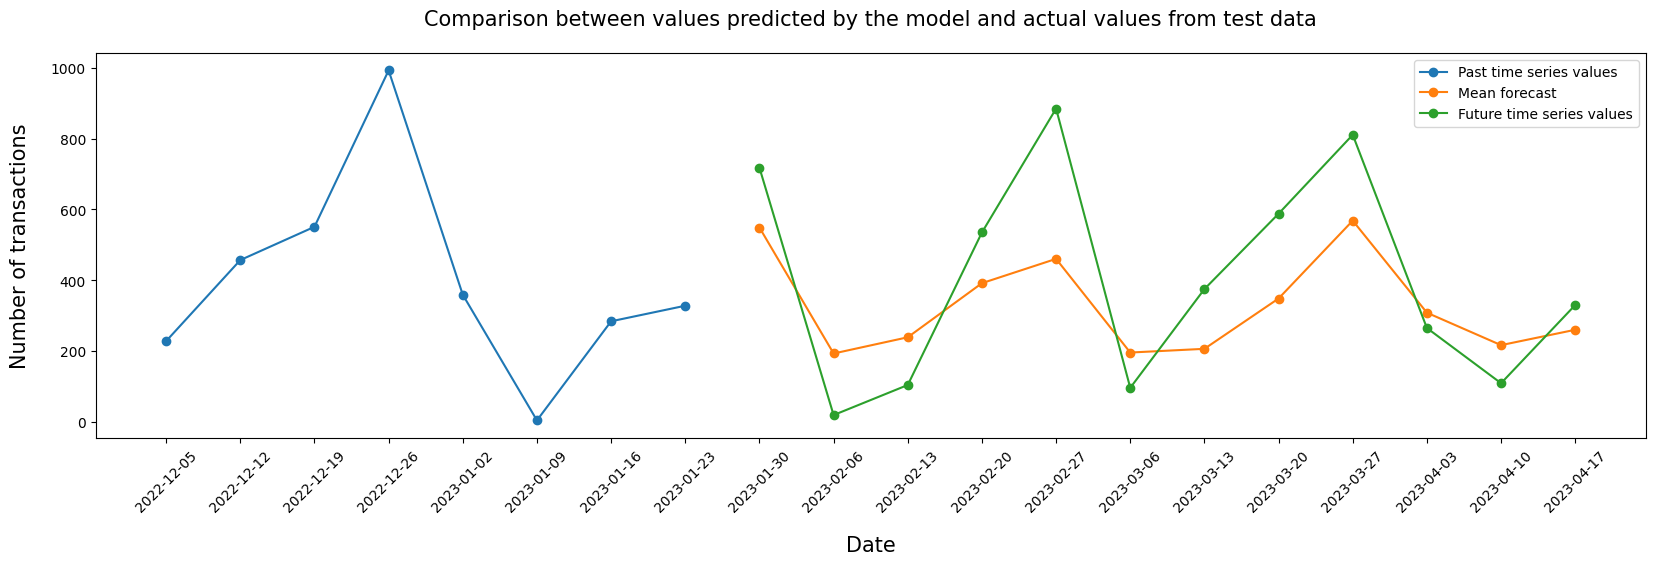

In [12]:
plt.figure(figsize=(20, 5))
plt.title("Comparison between values predicted by the model and actual values from test data", pad=20, fontsize=15)

item_id = "ACT01"
y_past = train_data.loc[item_id]["target"]
y_pred = predictions.loc[item_id]
y_test = test_data.loc[item_id]["target"][:12]

# Get the dates for each observation
all_dates = list(y_past.index[-8:]) + list(y_test.index)
all_ticks = range(len(all_dates))

# Set the x-axis range for past and future
past_ticks = range(8)
future_ticks = range(8, len(all_dates))

plt.plot(past_ticks, y_past[-8:], label="Past time series values", marker='o', linestyle='-')
plt.plot(future_ticks, y_pred["mean"], label="Mean forecast", marker='o', linestyle='-')
plt.plot(future_ticks, y_test, label="Future time series values", marker='o', linestyle='-')


# Set x-axis labels with dates without time
date_labels = [date.strftime("%Y-%m-%d") for date in all_dates]
plt.xticks(all_ticks, date_labels, rotation=45)

# Add label for x-axis and y-axis
plt.xlabel("Date", fontsize=15, labelpad=15)
plt.ylabel("Number of transactions", fontsize=15, labelpad=15)

plt.legend()
plt.show()

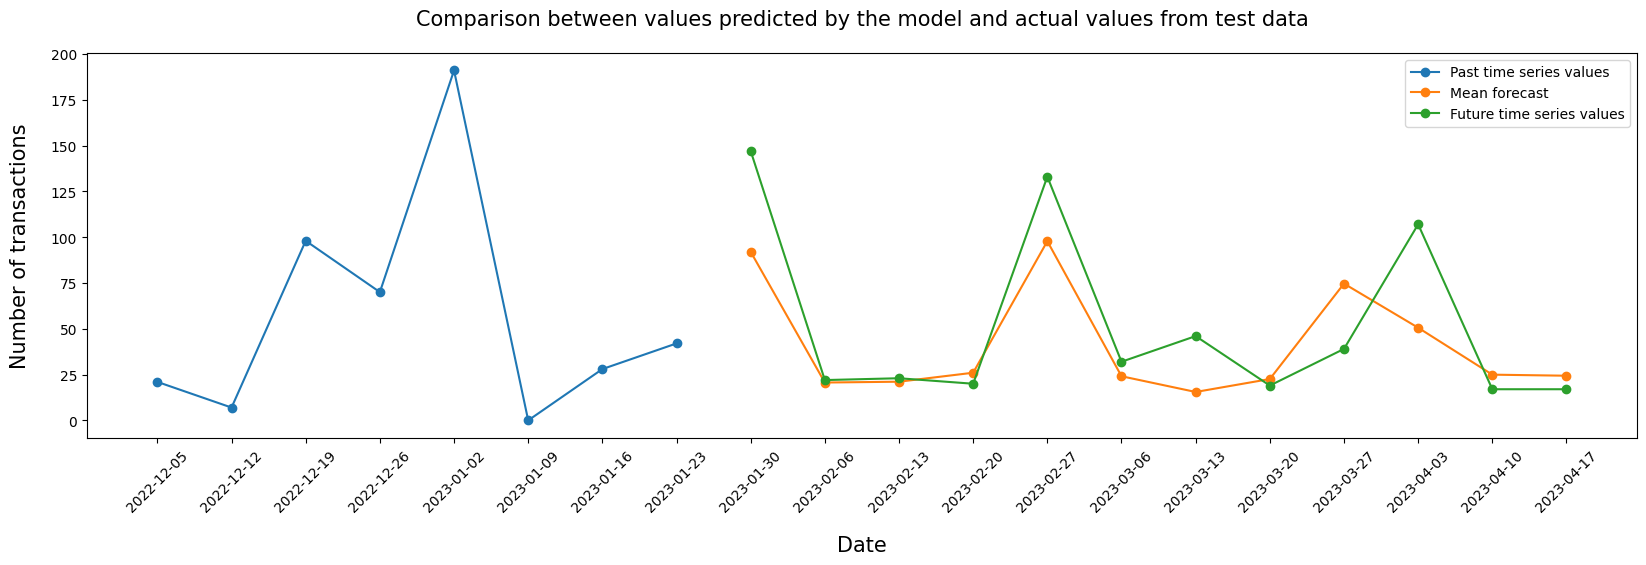

In [13]:
plt.figure(figsize=(20, 5))
plt.title("Comparison between values predicted by the model and actual values from test data", pad=20, fontsize=15)

item_id = "ACT03"
y_past = train_data.loc[item_id]["target"]
y_pred = predictions.loc[item_id]
y_test = test_data.loc[item_id]["target"][:12]

# Get the dates for each observation
all_dates = list(y_past.index[-8:]) + list(y_test.index)
all_ticks = range(len(all_dates))

# Set the x-axis range for past and future
past_ticks = range(8)
future_ticks = range(8, len(all_dates))

plt.plot(past_ticks, y_past[-8:], label="Past time series values", marker='o', linestyle='-')
plt.plot(future_ticks, y_pred["mean"], label="Mean forecast", marker='o', linestyle='-')
plt.plot(future_ticks, y_test, label="Future time series values", marker='o', linestyle='-')


# Set x-axis labels with dates without time
date_labels = [date.strftime("%Y-%m-%d") for date in all_dates]
plt.xticks(all_ticks, date_labels, rotation=45)

# Add label for x-axis and y-axis
plt.xlabel("Date", fontsize=15, labelpad=15)
plt.ylabel("Number of transactions", fontsize=15, labelpad=15)

plt.legend()
plt.show()

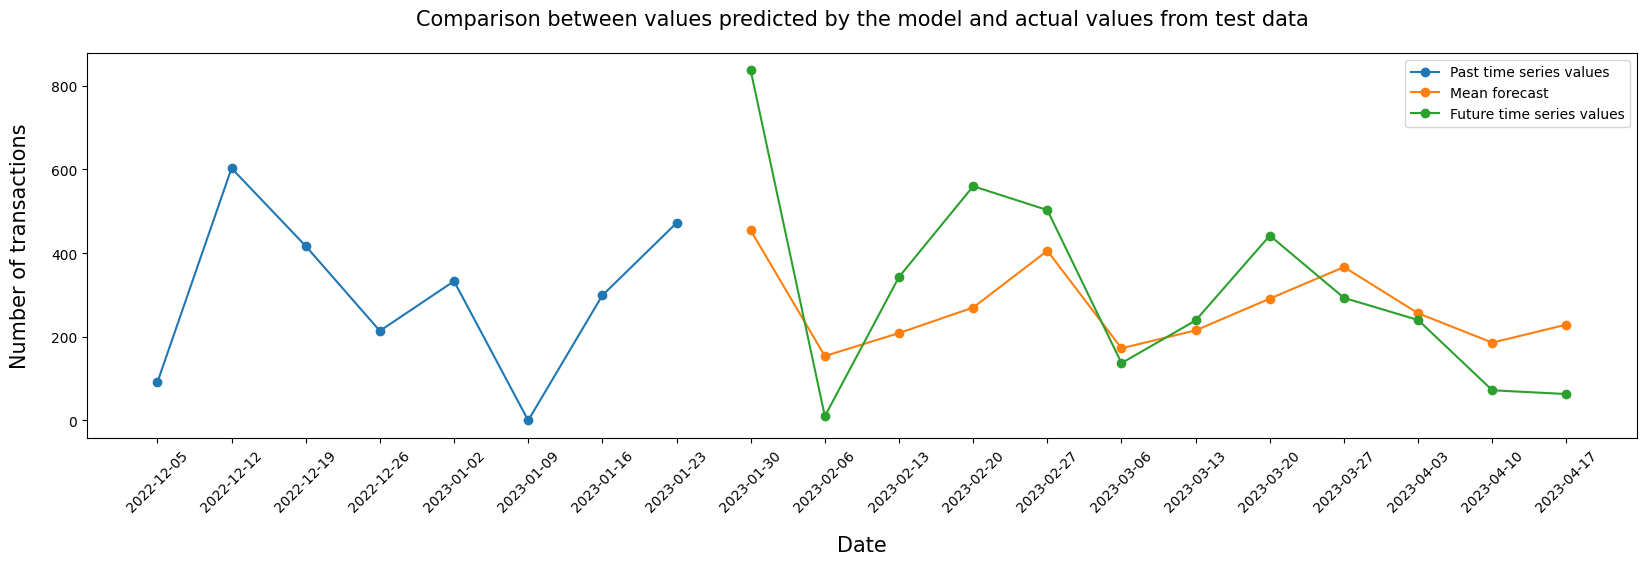

In [14]:
plt.figure(figsize=(20, 5))
plt.title("Comparison between values predicted by the model and actual values from test data", pad=20, fontsize=15)

item_id = "ACT07"
y_past = train_data.loc[item_id]["target"]
y_pred = predictions.loc[item_id]
y_test = test_data.loc[item_id]["target"][:12]

# Get the dates for each observation
all_dates = list(y_past.index[-8:]) + list(y_test.index)
all_ticks = range(len(all_dates))

# Set the x-axis range for past and future
past_ticks = range(8)
future_ticks = range(8, len(all_dates))

plt.plot(past_ticks, y_past[-8:], label="Past time series values", marker='o', linestyle='-')
plt.plot(future_ticks, y_pred["mean"], label="Mean forecast", marker='o', linestyle='-')
plt.plot(future_ticks, y_test, label="Future time series values", marker='o', linestyle='-')


# Set x-axis labels with dates without time
date_labels = [date.strftime("%Y-%m-%d") for date in all_dates]
plt.xticks(all_ticks, date_labels, rotation=45)

# Add label for x-axis and y-axis
plt.xlabel("Date", fontsize=15, labelpad=15)
plt.ylabel("Number of transactions", fontsize=15, labelpad=15)

plt.legend()
plt.show()

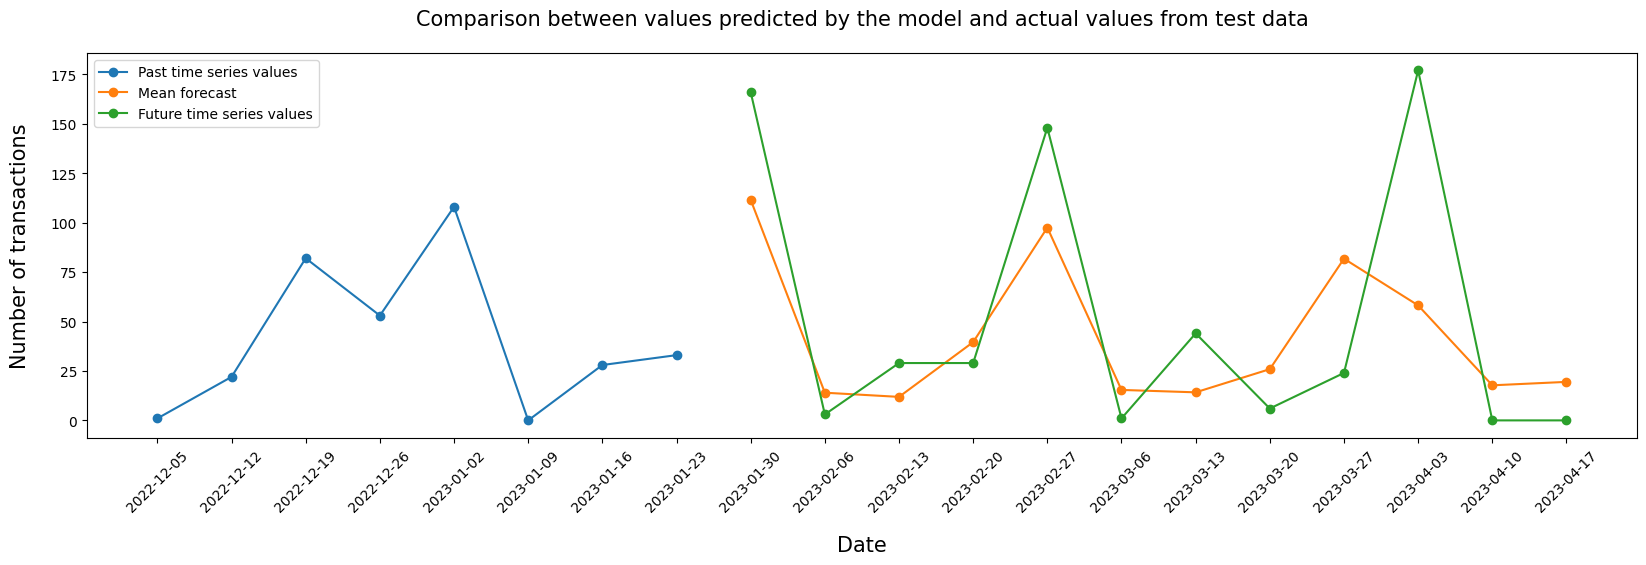

In [15]:
plt.figure(figsize=(20, 5))
plt.title("Comparison between values predicted by the model and actual values from test data", pad=20, fontsize=15)

item_id = "ACT09"
y_past = train_data.loc[item_id]["target"]
y_pred = predictions.loc[item_id]
y_test = test_data.loc[item_id]["target"][:12]

# Get the dates for each observation
all_dates = list(y_past.index[-8:]) + list(y_test.index)
all_ticks = range(len(all_dates))

# Set the x-axis range for past and future
past_ticks = range(8)
future_ticks = range(8, len(all_dates))

plt.plot(past_ticks, y_past[-8:], label="Past time series values", marker='o', linestyle='-')
plt.plot(future_ticks, y_pred["mean"], label="Mean forecast", marker='o', linestyle='-')
plt.plot(future_ticks, y_test, label="Future time series values", marker='o', linestyle='-')


# Set x-axis labels with dates without time
date_labels = [date.strftime("%Y-%m-%d") for date in all_dates]
plt.xticks(all_ticks, date_labels, rotation=45)

# Add label for x-axis and y-axis
plt.xlabel("Date", fontsize=15, labelpad=15)
plt.ylabel("Number of transactions", fontsize=15, labelpad=15)

plt.legend()
plt.show()

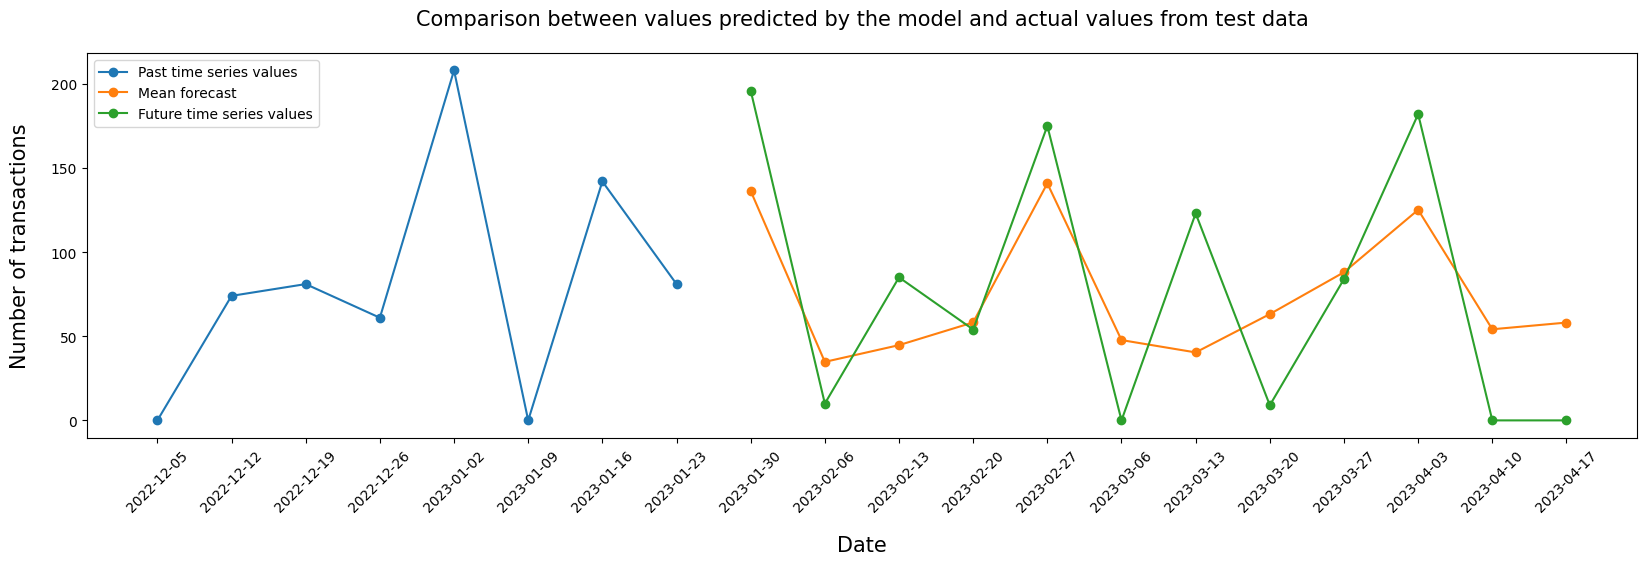

In [16]:
plt.figure(figsize=(20, 5))
plt.title("Comparison between values predicted by the model and actual values from test data", pad=20, fontsize=15)

item_id = "ACT13"
y_past = train_data.loc[item_id]["target"]
y_pred = predictions.loc[item_id]
y_test = test_data.loc[item_id]["target"][:12]

# Get the dates for each observation
all_dates = list(y_past.index[-8:]) + list(y_test.index)
all_ticks = range(len(all_dates))

# Set the x-axis range for past and future
past_ticks = range(8)
future_ticks = range(8, len(all_dates))

plt.plot(past_ticks, y_past[-8:], label="Past time series values", marker='o', linestyle='-')
plt.plot(future_ticks, y_pred["mean"], label="Mean forecast", marker='o', linestyle='-')
plt.plot(future_ticks, y_test, label="Future time series values", marker='o', linestyle='-')


# Set x-axis labels with dates without time
date_labels = [date.strftime("%Y-%m-%d") for date in all_dates]
plt.xticks(all_ticks, date_labels, rotation=45)

# Add label for x-axis and y-axis
plt.xlabel("Date", fontsize=15, labelpad=15)
plt.ylabel("Number of transactions", fontsize=15, labelpad=15)

plt.legend()
plt.show()

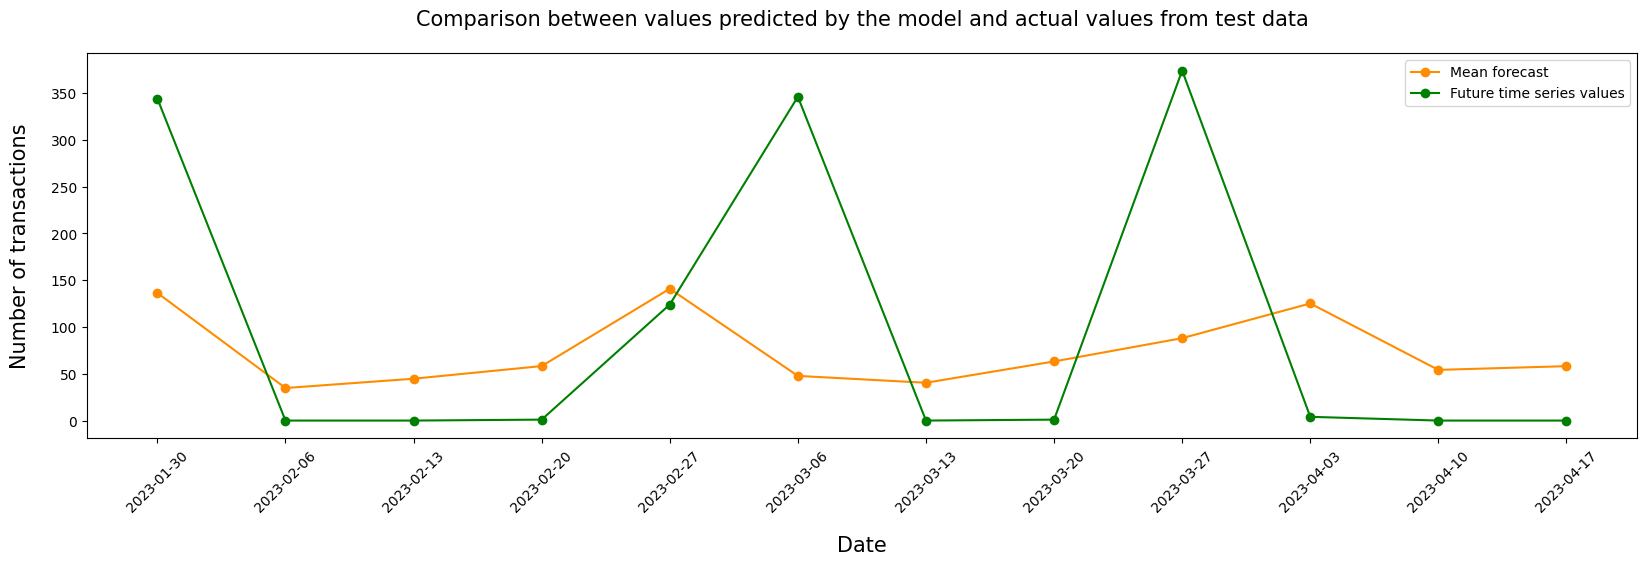

In [17]:
import numpy as np

# Set negative values of y_pred["mean"] to 0
y_pred_non_negative = np.maximum(y_pred["mean"], 0)

plt.figure(figsize=(20, 5))
plt.title("Comparison between values predicted by the model and actual values from test data", pad=20, fontsize=15)

item_id = "ACT15"
y_test = test_data.loc[item_id]["target"][:12]

# Get the dates for each observation
all_dates = list(y_test.index)
all_ticks = range(len(all_dates))

# Set the x-axis range for future
future_ticks = range(len(all_dates))

plt.plot(future_ticks, y_pred_non_negative, label="Mean forecast", color="darkorange", marker='o', linestyle='-')
plt.plot(future_ticks, y_test, label="Future time series values", color="green", marker='o', linestyle='-')

# Set x-axis labels with dates without time
date_labels = [date.strftime("%Y-%m-%d") for date in all_dates]
plt.xticks(all_ticks, date_labels, rotation=45)

# Add label for x-axis and y-axis
plt.xlabel("Date", fontsize=15, labelpad=15)
plt.ylabel("Number of transactions", fontsize=15, labelpad=15)

plt.legend()
plt.show()


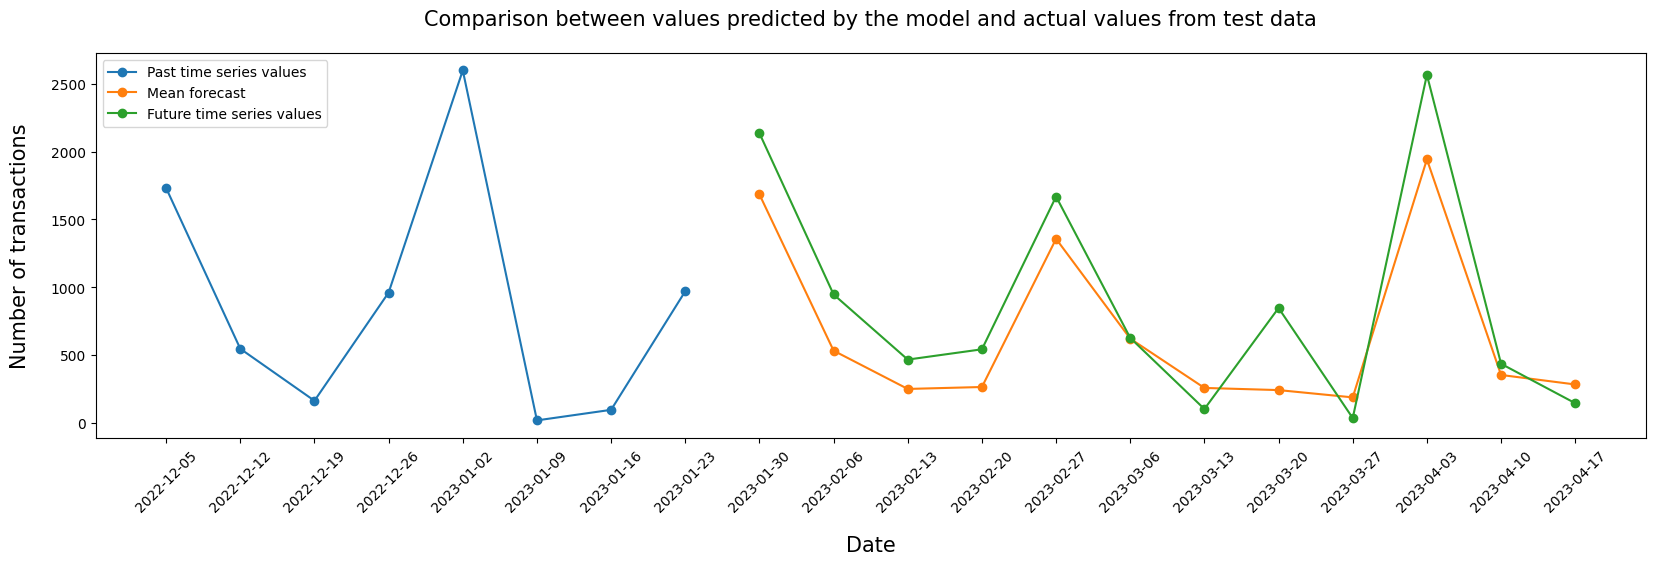

In [18]:
plt.figure(figsize=(20, 5))
plt.title("Comparison between values predicted by the model and actual values from test data", pad=20, fontsize=15)

item_id = "ACT32"
y_past = train_data.loc[item_id]["target"]
y_pred = predictions.loc[item_id]
y_test = test_data.loc[item_id]["target"][:12]

# Get the dates for each observation
all_dates = list(y_past.index[-8:]) + list(y_test.index)
all_ticks = range(len(all_dates))

# Set the x-axis range for past and future
past_ticks = range(8)
future_ticks = range(8, len(all_dates))

plt.plot(past_ticks, y_past[-8:], label="Past time series values", marker='o', linestyle='-')
plt.plot(future_ticks, y_pred["mean"], label="Mean forecast", marker='o', linestyle='-')
plt.plot(future_ticks, y_test, label="Future time series values", marker='o', linestyle='-')


# Set x-axis labels with dates without time
date_labels = [date.strftime("%Y-%m-%d") for date in all_dates]
plt.xticks(all_ticks, date_labels, rotation=45)

# Add label for x-axis and y-axis
plt.xlabel("Date", fontsize=15, labelpad=15)
plt.ylabel("Number of transactions", fontsize=15, labelpad=15)

plt.legend()
plt.show()

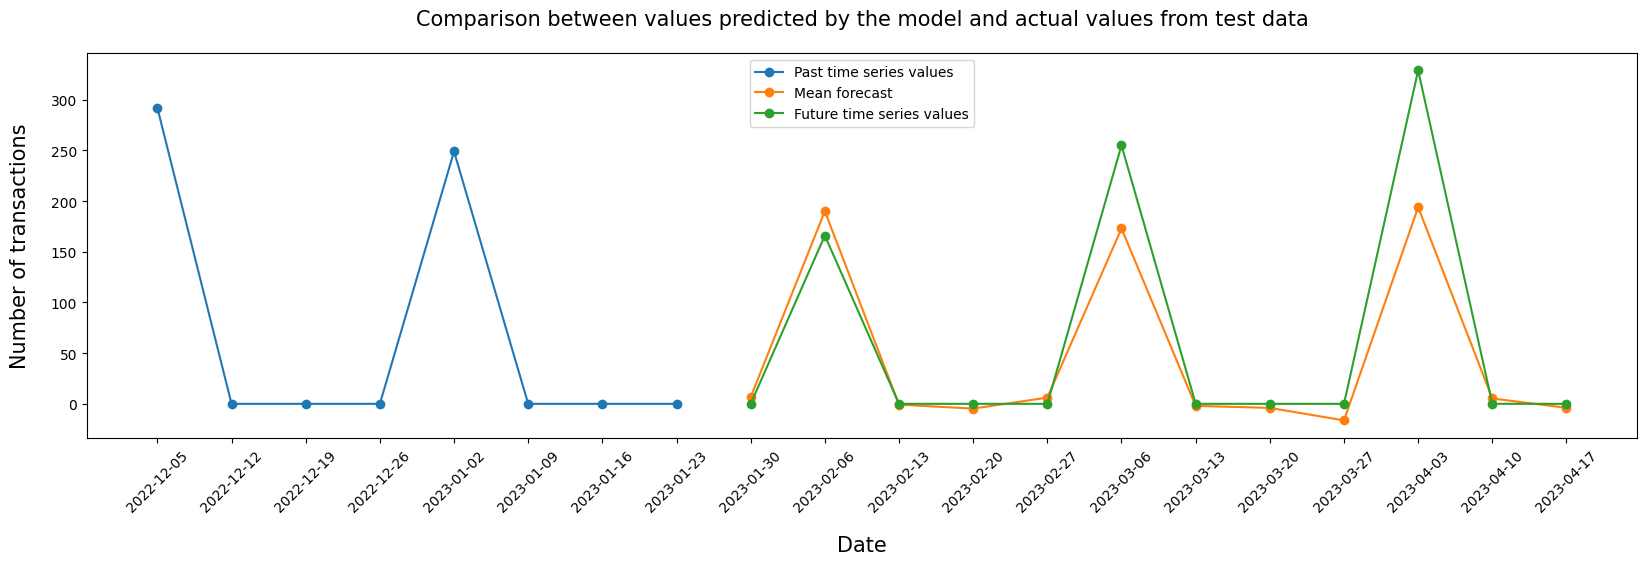

In [19]:
plt.figure(figsize=(20, 5))
plt.title("Comparison between values predicted by the model and actual values from test data", pad=20, fontsize=15)

item_id = "ACT34"
y_past = train_data.loc[item_id]["target"]
y_pred = predictions.loc[item_id]
y_test = test_data.loc[item_id]["target"][:12]

# Get the dates for each observation
all_dates = list(y_past.index[-8:]) + list(y_test.index)
all_ticks = range(len(all_dates))

# Set the x-axis range for past and future
past_ticks = range(8)
future_ticks = range(8, len(all_dates))

plt.plot(past_ticks, y_past[-8:], label="Past time series values", marker='o', linestyle='-')
plt.plot(future_ticks, y_pred["mean"], label="Mean forecast", marker='o', linestyle='-')
plt.plot(future_ticks, y_test, label="Future time series values", marker='o', linestyle='-')


# Set x-axis labels with dates without time
date_labels = [date.strftime("%Y-%m-%d") for date in all_dates]
plt.xticks(all_ticks, date_labels, rotation=45)

# Add label for x-axis and y-axis
plt.xlabel("Date", fontsize=15, labelpad=15)
plt.ylabel("Number of transactions", fontsize=15, labelpad=15)

plt.legend()
plt.show()